In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [8]:
b25_times_df = pd.read_csv(f'{EXPORTS_DIR}/b25_weekday_stop_times.csv')
b25_trjs_df = pd.read_csv(f'{EXPORTS_DIR}/b25_all_trajectories.csv')
b25_trjs_gdf = gpd.GeoDataFrame(b25_trjs_df, geometry=gpd.points_from_xy(b25_trjs_df['longitude'], b25_trjs_df['latitude']), crs=CRS_PLOT)

In [9]:
bus_ids = set(b25_trjs_gdf['bus_id'])

In [10]:
# Collect continuous trajectories into ID-grouped dictionary.
b25_trjs_dict = {}
for bus_id in bus_ids:
    df = b25_trjs_gdf[b25_trjs_gdf['bus_id'] == bus_id]
    direction = df.iloc[0]['x']

    trjs = []
    trj = []

    for i in range(0, len(df)):
        row = df.iloc[i]
        if row['x'] != direction:
            trjs.append(trj)
            trj = []
            direction = row['x']

        (x, y, t) = row[['longitude', 'latitude', 'datetime']]
        trj.append((x, y, t))
    trjs.append(trj)
    b25_trjs_dict[bus_id] = trjs

In [53]:
bk = ox.io.load_graphml('bk.graphml')
route_graph = ox.io.load_graphml('b25.graphml')

route_gdf = gpd.read_file(f'{EXPORTS_DIR}/b25_220.shp').iloc[1:]
route_graph_edges = ox.nearest_edges(bk, route_gdf['stop_lon'], route_gdf['stop_lat'])
route_graph_edge_nodes = [[e[0], e[1]] for e in route_graph_edges]

In [54]:
def dedup_consecutive(a):
    b = []
    last = None
    for i in range(0, len(a)):
        c = a[i]
        if c != last:
            last = c
            b.append(c)
    return b

In [55]:
route_graph_nodes = []
for i in range(0, len(route_graph_edge_nodes) - 1):
    edge0 = route_graph_edge_nodes[i]
    edge1 = route_graph_edge_nodes[i + 1]
    sp = ox.shortest_path(bk, edge0[1], edge1[0])
    if sp is None:
        raise Exception('oof')
    nd = dedup_consecutive(edge0 + sp + [edge1[0]])
    route_graph_nodes += nd

route_graph_nodes = dedup_consecutive(route_graph_nodes)

In [56]:
def snap_to_edge(point, edge):
    p1 = edge[0]
    p2 = edge[1]
    x1 = float(p1[0])
    y1 = float(p1[1])
    x2 = float(p2[0])
    y2 = float(p2[1])
    x3 = point[0]
    y3 = point[1]
    
    m1 = (y2 - y1) / (x2 - x1)
    m3 = -1.0 / m1
    x = (m1 * x1 - m3 * x3 - y1 + y3) / (m1 - m3)
    y = m1 * (x - x1) + y1
    return [x, y]

In [57]:
class RouteNode:
    def __init__(self, i=0, id=0, node=None):
        self.i = i
        self.id = id
        self.node = node
        self.next_node = None
        self.x = node['x']
        self.y = node['y']
        self.t = 0
        self.st = 0
        
    def set_next_node(self, next_node):
        self.next_node = next_node
        self.distance_to_next =ox.distance.euclidean_dist_vec(self.y, self.x, next_node.y, next_node.x)

class Stop:
    def __init__(self, i=0, x=0, y=0, t=0):
        self.i = i
        self.x = x
        self.y = y
        self.t = t
        self.st = 0
        
        self.edge = ox.nearest_edges(route_graph, [self.x], [self.y])[0]
        
        self.prev_node_id = self.edge[0]
        self.next_node_id = self.edge[1]
        self.prev_node_index = route_graph_nodes.index(self.prev_node_id)
        try:
            self.next_node_index = route_graph_nodes.index(self.next_node_id, self.prev_node_index)
        except ValueError:
            self.next_node_index = route_graph_nodes.index(self.next_node_id)
        
        self.prev_node = route_graph.nodes[self.prev_node_id]
        self.next_node = route_graph.nodes[self.next_node_id]
        
        route_point = snap_to_edge([x, y], [[self.prev_node['x'], self.prev_node['y']], [self.next_node['x'], self.next_node['y']]])
        self.rx = route_point[0]
        self.ry = route_point[1]
        
        self.prev_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.prev_node['y'], self.prev_node['x'])
        self.next_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.next_node['y'], self.next_node['x'])
        
    def get_nearest_edge(self):
        edge = ox.nearest_edges(route_graph, route_gdf['stop_lon'], route_gdf['stop_lat'])
        
class TrajectoryPoint(Stop):
    def __init__(self, i=0, x=0, y=0, t=0):
        super().__init__(i, x, y, t)
        
        next_node_t = route_node_list[self.next_node_index].t
        prev_node_t = route_node_list[self.prev_node_index].t
        
        if next_node_t == 0:
            self.t_expected = None
        elif prev_node_t == 0:
            self.t_expected = None
        else:
            next_node_t -= datetime.timedelta(days=51)
            prev_node_t -= datetime.timedelta(days=51)
            self.t_expected = (self.prev_node_dist / (self.prev_node_dist + self.next_node_dist)) * (next_node_t - prev_node_t) + prev_node_t

In [58]:
route_nodes = []

for i in range(0, len(route_graph_nodes)):
    id = route_graph_nodes[i]
    route_nodes.append(RouteNode(i, id, route_graph.nodes[id]))
    
for i in range(0, len(route_graph_nodes) - 1):
    route_nodes[i].set_next_node(route_nodes[i + 1])

In [59]:
stops = []
for i in range(0, len(route_gdf)):
    row = route_gdf.iloc[i]
    stop = Stop(i=0, x=row['stop_lon'], y=row['stop_lat'], t=row['departure_'])
    stops.append(stop)

In [60]:
trajectory_df = pd.read_csv(f'{EXPORTS_DIR}/b25_4845.csv')
trajectory_gdf = gpd.GeoDataFrame(trajectory_df, geometry=gpd.points_from_xy(trajectory_df['longitude'], trajectory_df['latitude']), crs=CRS_PLOT)
trajectory_gdf['datetime'] = pd.to_datetime(trajectory_gdf['datetime'])
trajectory_gdf

trajectory_points = []
for i in range(0, len(trajectory_gdf)):
    row = trajectory_gdf.iloc[i]
    trajectory_points.append(TrajectoryPoint(i=0, x=row['longitude'], y=row['latitude'], t=row['datetime']))

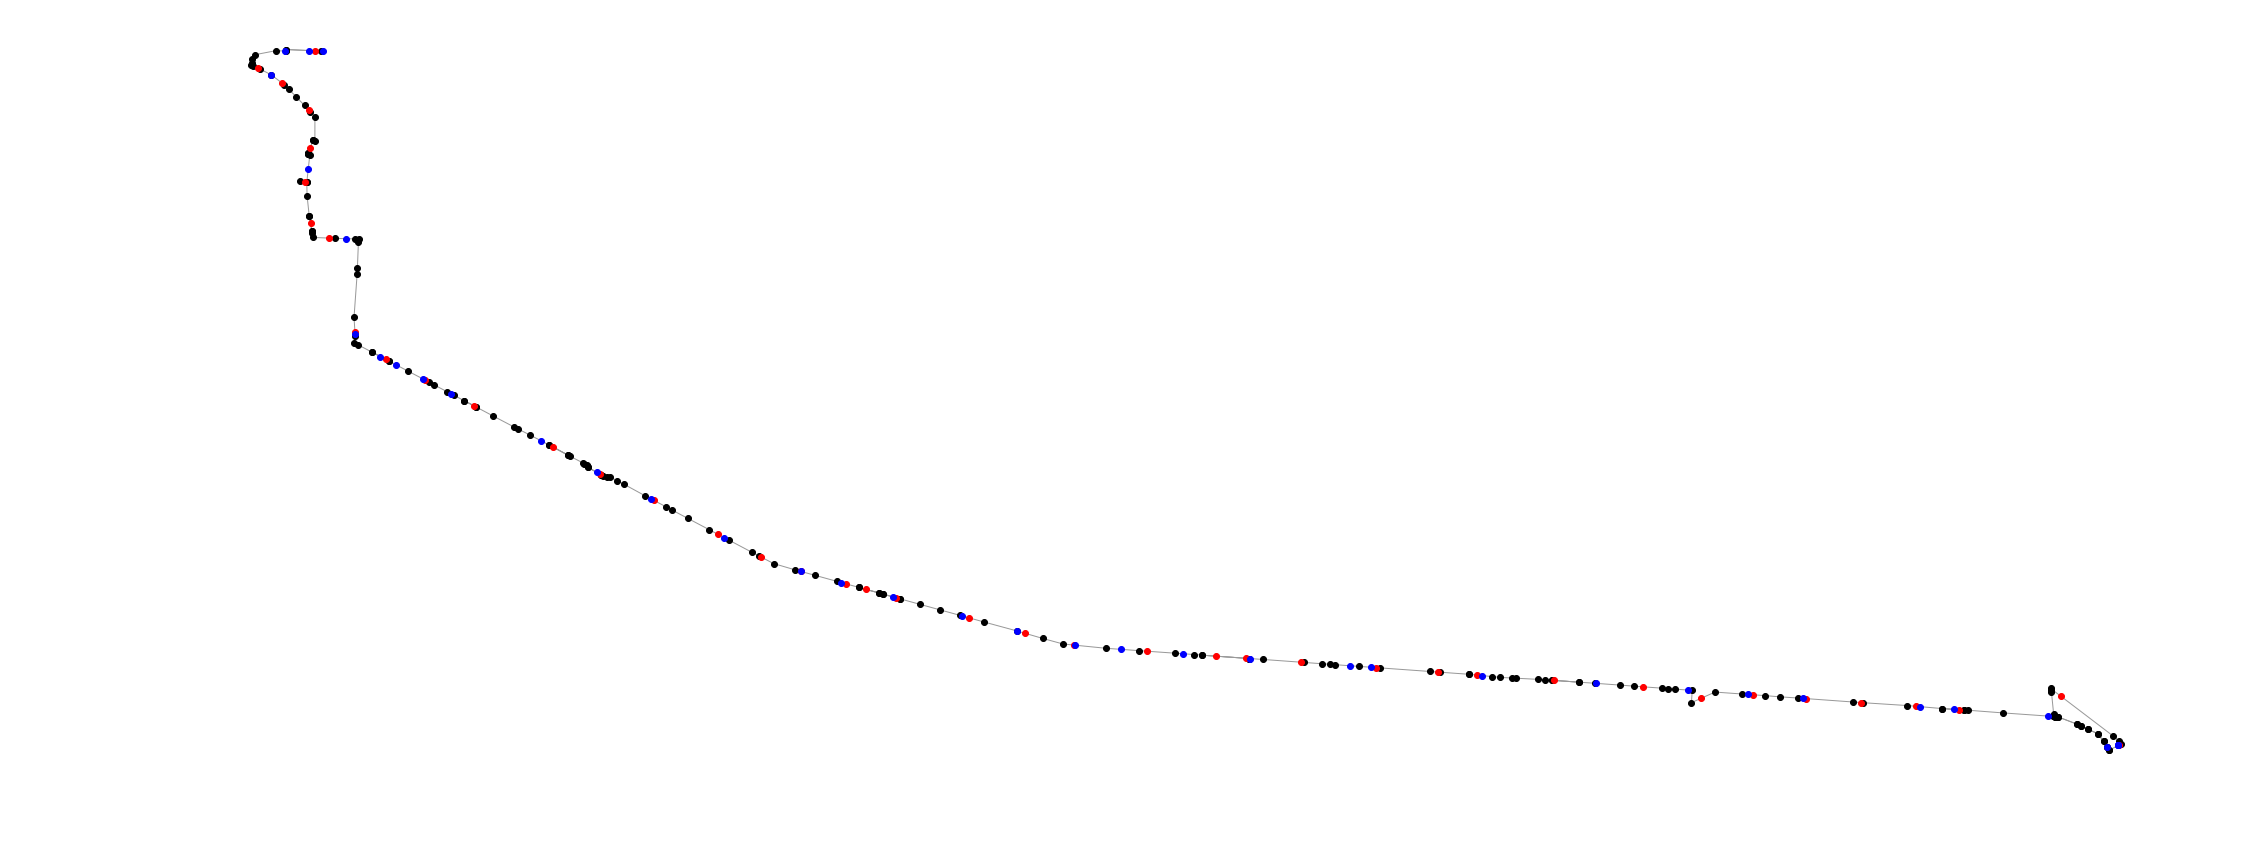

In [61]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)

X = [route_graph.nodes[n]['x'] for n in route_graph_nodes]
Y = [route_graph.nodes[n]['y'] for n in route_graph_nodes]
ax.scatter(X, Y, color='black')

X = [t.rx for t in stops]
Y = [t.ry for t in stops]
ax.scatter(X, Y, color='red')

X = [t.rx for t in trajectory_points]
Y = [t.ry for t in trajectory_points]
ax.scatter(X, Y, color='blue')

plt.show()

In [67]:
# Calculate the actual time at each route node based on the trajectory times.
for k in range(0, len(trajectory_points) - 1):
    trajectory_point = trajectory_points[k] 
    trajectory_point.next_node_index
    next_trajectory_point = trajectory_points[k + 1]
    next_trajectory_point.prev_node_index

    total_dist = trajectory_point.next_node_dist
    for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
        total_dist += route_nodes[i].distance_to_next
    total_dist += next_trajectory_point.prev_node_dist
    t0 = trajectory_point.t
    t1 = next_trajectory_point.t

    for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
        node_dist = 0
        for j in range(i, next_trajectory_point.prev_node_index + 1):
            node_dist += route_nodes[j].distance_to_next
        node_dist += next_trajectory_point.prev_node_dist

        ratio = (total_dist - node_dist) / total_dist
        route_nodes[i].st = (t1 - t0) * ratio + t0

In [71]:
# Calculate the actual time at each stop based on the trajectory times.
for k in range(0, len(stops) - 1):
    stop = stops[k]
    stop_prev_node = route_nodes[stop.prev_node_index]
    stop_next_node = route_nodes[stop.next_node_index]
    if stop_prev_node.st != 0 and stop_next_node.st != 0:
        ratio = stop.prev_node_dist / (stop.prev_node_dist + stop.next_node_dist)
        t0 = stop_prev_node.st
        t1 = stop_next_node.st
        stop.st = (t1 - t0) * ratio + t0

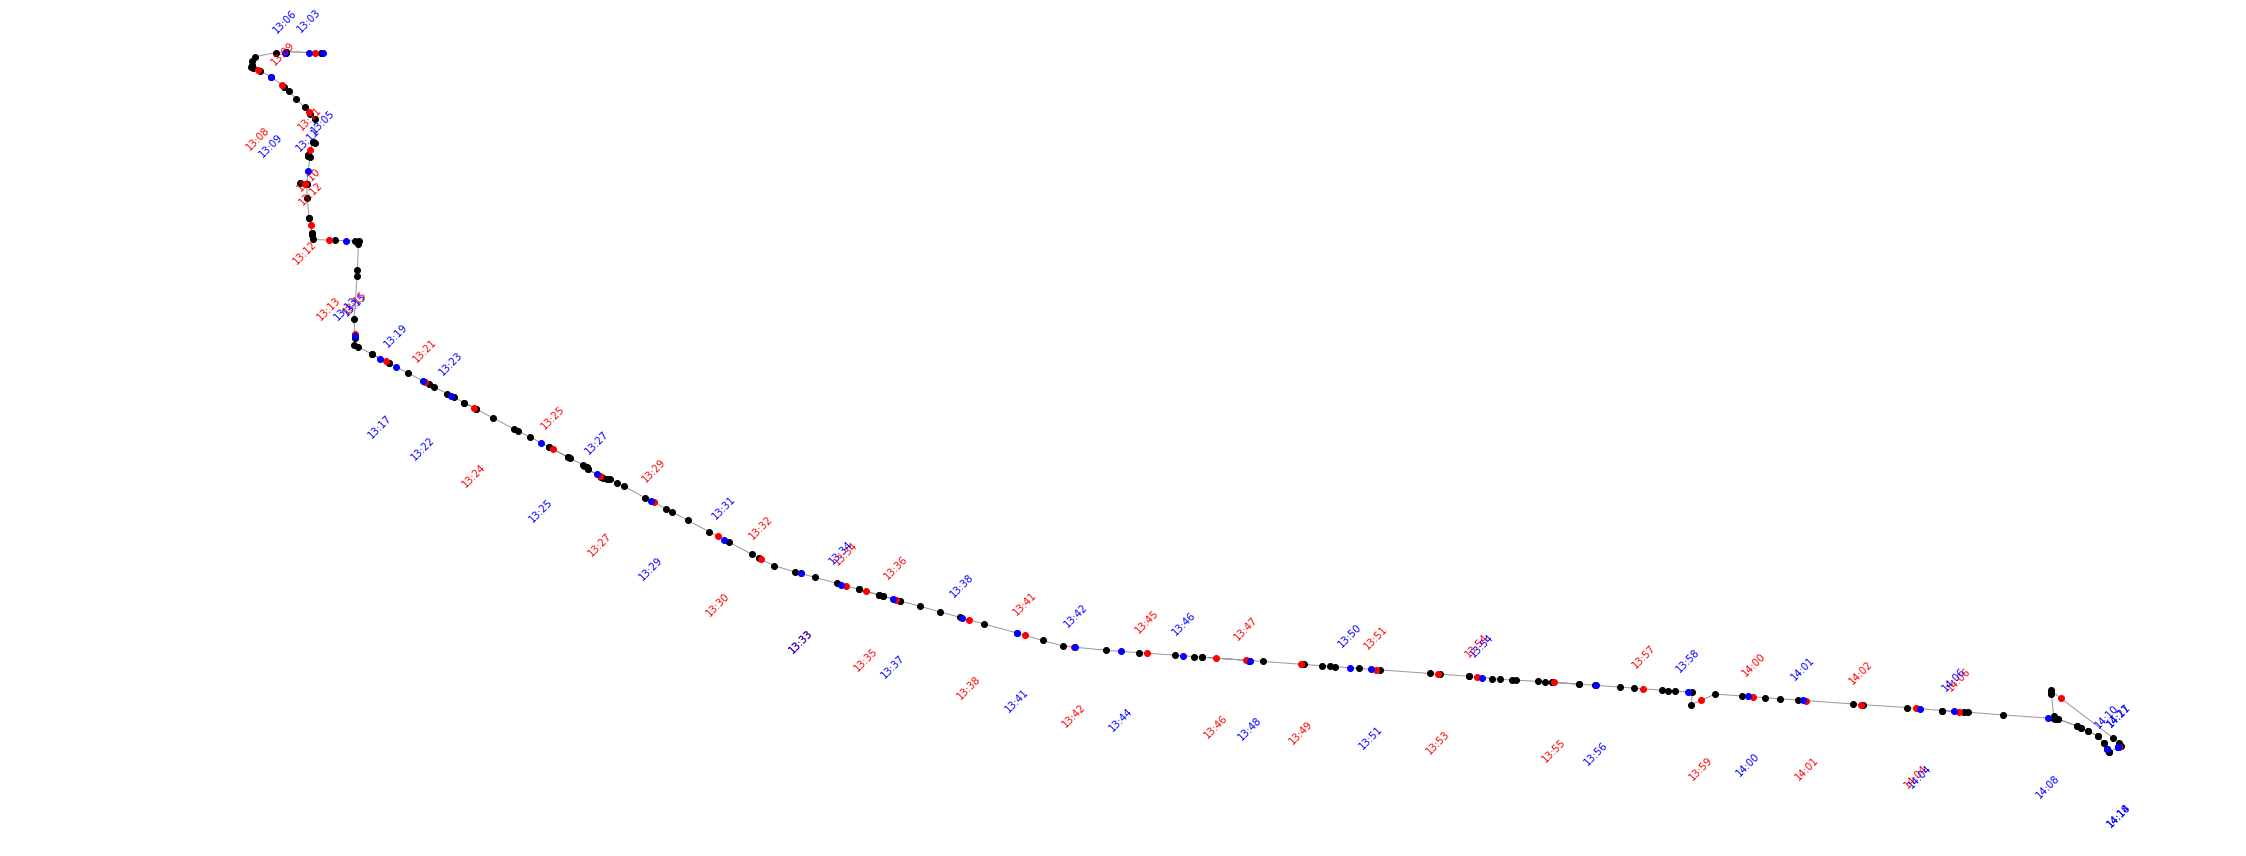

In [72]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)

X = [route_graph.nodes[n]['x'] for n in route_graph_nodes]
Y = [route_graph.nodes[n]['y'] for n in route_graph_nodes]
ax.scatter(X, Y, color='black')

X = [t.rx for t in stops]
Y = [t.ry for t in stops]
ax.scatter(X, Y, color='red')
        
for i in range(0, len(stops)):
    x = X[i]
    y = Y[i]
    k = 1 if i % 2 == 0 else -4
    stop = stops[i]
    if stop.st != None and stop.st != 0:
        ax.annotate(stop.st.strftime('%H:%M'), (x, y),
                   xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='red')

X = [t.rx for t in trajectory_points]
Y = [t.ry for t in trajectory_points]
ax.scatter(X, Y, color='blue')

for i in range(0, len(trajectory_points)):
    x = X[i]
    y = Y[i]
    k = 1 if i % 2 == 0 else -4
    tp = trajectory_points[i]
    if tp.t != 0:
        ax.annotate(tp.t.strftime('%H:%M'), (x, y),
                   xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='blue')

plt.show()

In [66]:
stop_times_df = pd.read_csv(f'{EXPORTS_DIR}/b25_weekday_stop_times.csv')
stop_times_df

,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
0,EN_B1-Weekday-SDon-005800_B25_201,00:58:00,00:58:55,01:00:19,01:00:49,01:01:28,01:02:13,01:02:46,01:03:30,01:04:00,...,01:27:53,01:29:11,01:30:00,01:31:13,01:32:26,01:33:42,01:34:58,01:35:57,01:38:04,01:40:00
1,EN_B1-Weekday-SDon-014400_B25_201,02:24:00,02:24:46,02:25:56,02:26:21,02:26:53,02:27:31,02:27:58,02:28:35,02:29:00,...,02:49:53,02:51:11,02:52:00,02:52:59,02:53:57,02:54:57,02:55:58,02:56:45,02:58:27,03:00:00
2,EN_B1-Weekday-SDon-021800_B25_201,03:38:00,03:38:46,03:39:56,03:40:21,03:40:53,03:41:31,03:41:58,03:42:35,03:43:00,...,04:03:53,04:05:11,04:06:00,04:06:59,04:07:57,04:08:57,04:09:58,04:10:45,04:12:27,04:14:00
3,EN_B1-Weekday-SDon-029200_B25_201,04:52:00,04:52:46,04:53:56,04:54:21,04:54:53,04:55:31,04:55:58,04:56:35,04:57:00,...,05:17:53,05:19:11,05:20:00,05:20:59,05:21:57,05:22:57,05:23:58,05:24:45,05:26:27,05:28:00
4,EN_B1-Weekday-SDon-033200_Q56_453,05:32:00,05:33:04,05:34:42,05:35:17,05:36:02,05:36:55,05:37:34,05:38:25,05:39:00,...,06:03:37,06:05:05,06:06:00,06:07:13,06:08:26,06:09:42,06:10:58,06:11:57,06:14:04,06:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,EN_B1-Weekday-130900_B83_317,21:49:00,21:50:23,21:52:28,21:53:14,21:54:11,21:55:19,21:56:09,21:57:15,21:58:00,...,22:32:49,22:34:46,22:36:00,22:37:21,22:38:41,22:40:04,22:41:27,22:42:32,22:44:52,22:47:00
100,EN_B1-Weekday-133200_B25_238,22:12:00,22:13:23,22:15:28,22:16:14,22:17:11,22:18:19,22:19:09,22:20:15,22:21:00,...,22:55:49,22:57:46,22:59:00,23:00:21,23:01:41,23:03:04,23:04:27,23:05:32,23:07:52,23:10:00
101,EN_B1-Weekday-135700_B25_235,22:37:00,22:38:23,22:40:28,22:41:14,22:42:11,22:43:19,22:44:09,22:45:15,22:46:00,...,23:18:05,23:19:52,23:21:00,23:22:13,23:23:26,23:24:42,23:25:58,23:26:57,23:29:04,23:31:00
102,EN_B1-Weekday-138200_B83_319,23:02:00,23:03:23,23:05:28,23:06:14,23:07:11,23:08:19,23:09:09,23:10:15,23:11:00,...,23:40:21,23:41:59,23:43:00,23:44:13,23:45:26,23:46:42,23:47:58,23:48:57,23:51:04,23:53:00


In [74]:
columns = list(route_gdf['stop_id'])
route_actual_times = pd.DataFrame({column: [stop.st.strftime('%H:%M:%S') if stop.st != 0 else None] for (column, stop) in zip(columns, stops)}, columns=columns)

In [75]:
start_col = route_actual_times.columns[1]
actual_time = pd.to_datetime(route_actual_times[start_col].iloc[0])

In [ ]:
from datetime import timedelta
stop_diffs_df = stop_times_df.copy()[['trip_id', str(start_col)]]
stop_diffs_df[str(start_col)] = pd.to_datetime(stop_diffs_df[str(start_col)])
stop_diffs_df['diff'] = stop_diffs_df[str(start_col)] - actual_time
threshold = 5
matching_df = stop_diffs_df[(stop_diffs_df['diff'] < timedelta(minutes=threshold)) & (stop_diffs_df['diff'] > timedelta(minutes=-threshold))]
matching_trips = list(matching_df['trip_id'])
matching_df